In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

data = pd.read_csv("Thecleverprogrammer.csv")
print(data.head())

         Date  Views
0  01/06/2021   7831
1  02/06/2021   7798
2  03/06/2021   7401
3  04/06/2021   7054
4  05/06/2021   7973


In [14]:
data["Date"] = pd.to_datetime(data["Date"], 
                              format="%d/%m/%Y")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    391 non-null    datetime64[ns]
 1   Views   391 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.2 KB
None


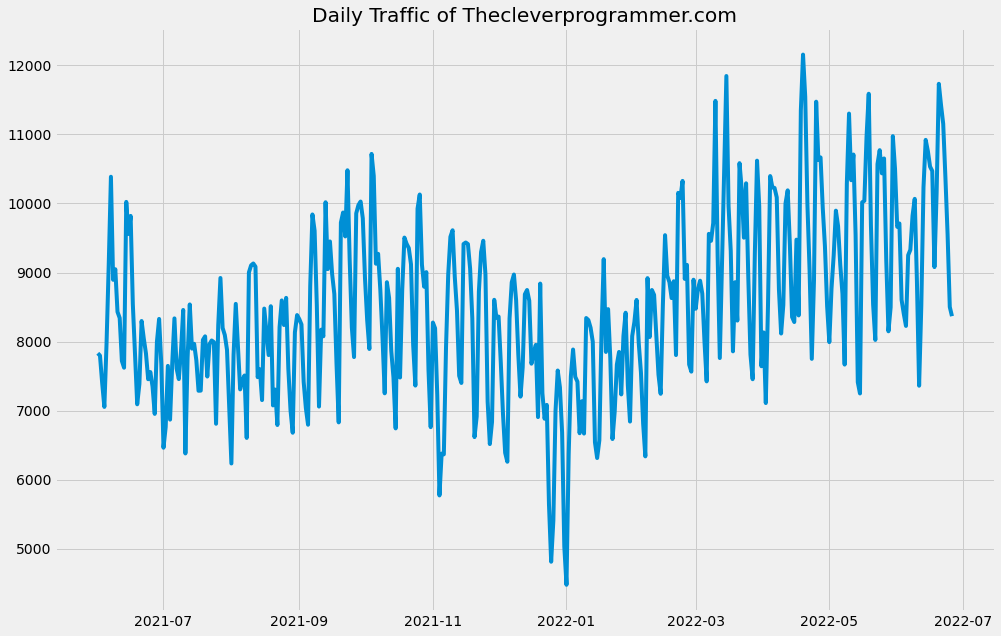

In [15]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Views"])
plt.title("Daily Traffic of Thecleverprogrammer.com")
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

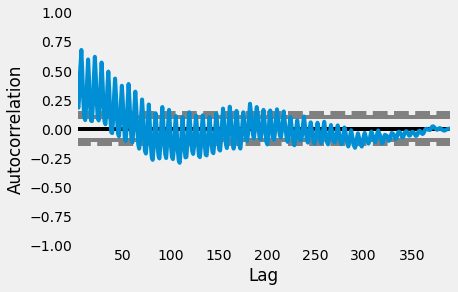

In [18]:
pd.plotting.autocorrelation_plot(data["Views"])

In [11]:
predictions = model.predict(len(data), len(data)+50)
print(predictions)

391     9862.560866
392    10764.483641
393    10721.995890
394     9837.168835
395     8752.502809
396     8196.620187
397     8903.975064
398     9679.184815
399    10268.496275
400    10589.224994
401     9783.664314
402     9312.838776
403     9013.807059
404     9055.159019
405    10527.083770
406    10987.584813
407    10837.676321
408    10016.830359
409     9398.883637
410     8593.783610
411     9138.783965
412    10392.964980
413    10590.455491
414    10764.284693
415    10219.721562
416     9402.067711
417     9027.923795
418     9161.237159
419     9904.297014
420    10233.978265
421    10688.960822
422     9853.892705
423     9506.440507
424     9039.923187
425     8781.654393
426    10107.756215
427    10820.430295
428    10871.065000
429    10349.770775
430     9383.537246
431     8622.265320
432     8665.377159
433    10035.814138
434    10482.309070
435    10796.543501
436    10434.471486
437     9270.747219
438     9130.200194
439     9328.257865
440    10284.825672


<AxesSubplot:>

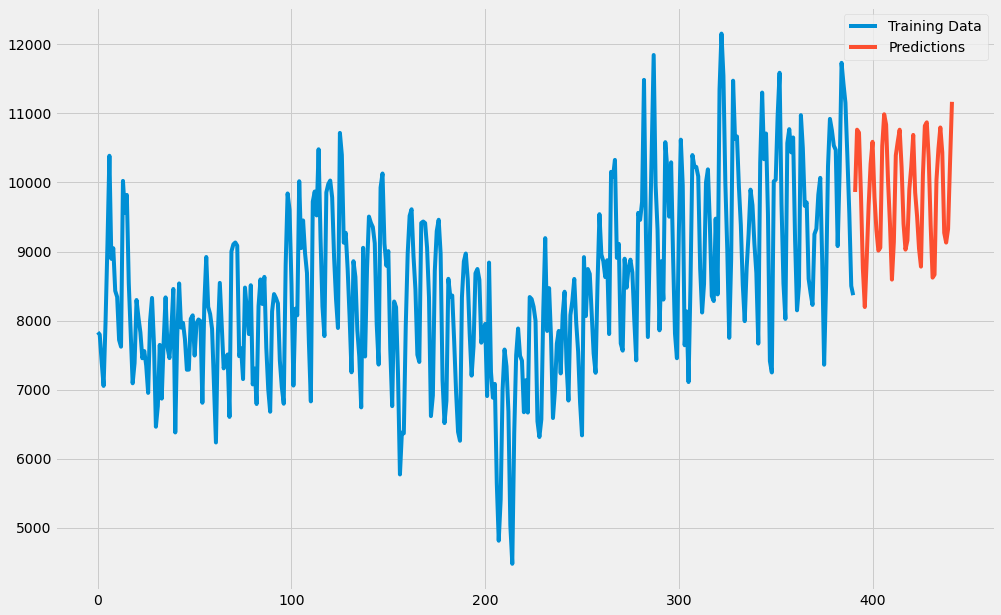

In [12]:
data["Views"].plot(legend=True, label="Training Data", 
                   figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")